# Examples of the EMI paper
In this Jupyter notebook are replicated the case studies withthe code and graph from the EMI paper (TODO add DOI).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime
import pandas as pd
sys.path.append('../src')
from emagpy import Problem

datadir = 'examples/'
outputdir = 'figures/'

letters = ['a','b','c','d','e','f','g','h','i','j']

## Inversion of an water-born survey over the river Leith

163.6528850803675 161.2438715998737


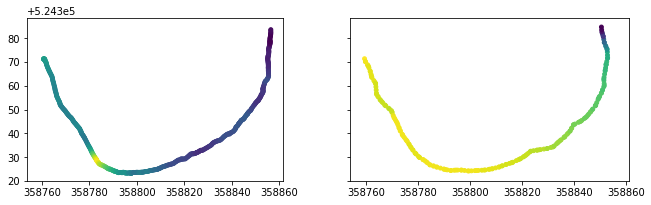

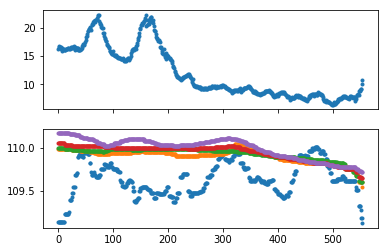

In [4]:
# interpolate head data to EMI survey
from scipy.interpolate import griddata
dfem = pd.read_csv(datadir + 'leith/leith_emi.csv') # collected up flow
dfem = dfem[::-1].reset_index(drop=True)
dfhead = pd.read_csv(datadir + 'leith/heads3.csv') # collected down flow
cols = dfhead.columns[3:]
# Z is elevation of river depth and Stage is elevation of water level
xi = dfem['x'].values
yi = dfem['y'].values
x = dfhead['East(m)'].values
y = dfhead['North(m)'].values

# compute start and end of overlapping data
istart = np.argmin(np.abs(np.sqrt((xi[0]-x)**2+(yi[0]-y)**2)))
iend = np.argmin(np.abs(np.sqrt((xi-x[-1])**2+(yi-y[-1])**2)))
dfem2 = dfem[:iend]
dfhead2 = dfhead[istart:].reset_index(drop=True)

# top view
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,3))
axs[0].scatter(dfem2['x'], dfem2['y'], s=15, c=dfem2['VCP4.49'])
axs[1].scatter(dfhead2['East(m)'], dfhead2['North(m)'], s=15, c=dfhead2['H20cm(m)'])
axs[0].set_aspect('equal')

# interpolate heads on EMI data based on nearest coordinates
xy = dfem2[['x','y']].values
dfem2.loc[:,'dist'] = 0
dfem2.loc[1:,'dist'] = np.cumsum(np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1)))
xy = dfhead2[['East(m)', 'North(m)']].values
dfhead2.loc[:,'dist'] = 0
dfhead2.loc[1:,'dist'] = np.cumsum(np.sqrt(np.sum(np.diff(xy, axis=0)**2, axis=1)))
print(dfem2['dist'].values[-1], dfhead2['dist'].values[-1])
for col in cols:
#     dfem2.loc[:,col] = np.interp(dfem2['dist'].values, dfhead2['dist'].values,
#                                  dfhead2[col].values)
    # flat at the end because of distance discremancies between the two survey
    dfem2.loc[:,col] = griddata(dfhead2[['East(m)', 'North(m)']].values,
                               dfhead2[col].values, dfem2[['x','y']].values, method='nearest')

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(dfem2['HCP4.49'], '.')
axs[1].plot(dfem2[cols], '.')

# compute topography as elevation of the surface of the water
dfem2.loc[:,'elevation'] = dfem2['Z(m)'] + dfem2['depth']
# river bed elevation + height of water

dfem2.to_csv(datadir + 'leith/leith_dataset.csv', index=False)

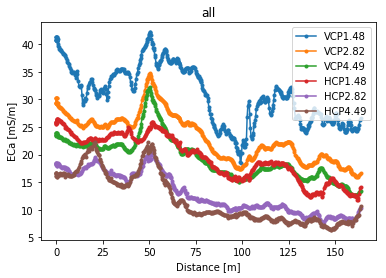

In [5]:
k = Problem()
k.createSurvey(datadir + 'leith/leith_dataset.csv')
k.show(dist=True)

In [21]:
# fixed depths
k = Problem()
k.createSurvey(datadir + 'leith/leith_dataset.csv')
depths = k.surveys[0].df['depth'].values # measured water depths
# setting initial model with top layer (the river) with fixed EC of 48 mS/m (measured)
k.setInit(depths0=depths[:,None], conds0=[48, 20], fixedConds=[True, False])
k.invert(njobs=-1, beta=0.1, alpha=0) # beta > 0 will cause lateral smoothing
# k.setInit(depths0=np.linspace(0.1, 2, 20))
# k.invert(forwardModel='CSgn')

Removing 9 NaN from survey
Survey 1/1
543/543 inverted


In [5]:
# fixed depths
k = Problem()
k.createSurvey(datadir + 'leith/leith_dataset.csv')
wdepths = k.surveys[0].df['depth'].values # measured water depths
depths = np.c_[wdepths, wdepths + 0.2, wdepths + 0.4, wdepths + 0.6, wdepths + 0.8, wdepths + 1]
# setting initial model with top layer (the river) with fixed EC of 48 mS/m (measured)
k.setInit(depths0=depths, conds0=[48, 20, 20, 20, 20, 20, 20], fixedConds=[True, False, False, False, False, False, False])
k.invert(njobs=-1, beta=0.0, alpha=0.07) # beta > 0 will cause lateral smoothing
# k.setInit(depths0=np.linspace(0.1, 2, 20))
# k.invert(forwardModel='CSgn')

  0%|          | 0/543 [00:00<?, ?it/s]

Removing 9 NaN from survey
Survey 1/1


100%|██████████| 543/543 [01:53<00:00,  4.79it/s]


In [7]:
# free depths
k2 = Problem()
k2.createSurvey(datadir + 'leith/leith_dataset.csv')
k2.surveys[0].df = k2.surveys[0].df # larger sampling
k2.setInit(depths0=[0.5], conds0=[40, 20], fixedDepths=[False], fixedConds=[True, False])
k2.invert(method='ROPE', njobs=-1, bnds=[(0.1, 1), (10, 20)], beta=0.1)

Survey 1/1
111/111 inverted


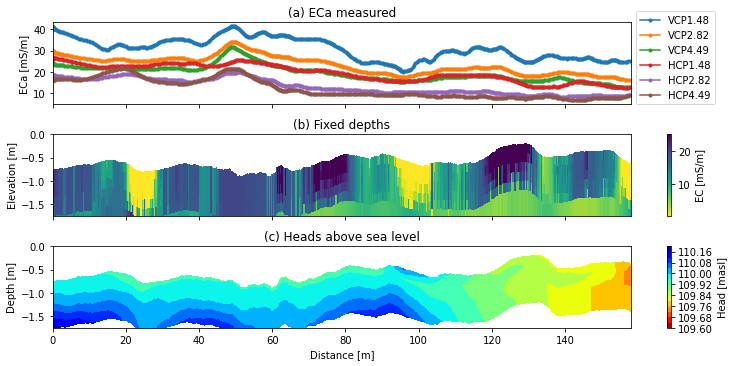

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

k.show(ax=ax0, dist=True)
ax0.set_title('(a) ECa measured')
ax0.set_xlabel('')
ax0.get_legend().remove()
ax0.legend(k.coils, bbox_to_anchor=(1,1.2))

current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='white')
k.models[0][:,0] = np.nan
k.showResults(ax=ax1, contour=False, dist=True)
ax1.set_title('(b) Fixed depths')
ax1.set_xlabel('')
ax1.set_ylim([-1.75, 0])

# k2.showResults(ax=ax2, contour=False, dist=True)
# ax2.set_title('(c) Free depths')
# ax2.step(k.surveys[0].df['dist'], -k.surveys[0].df['depth'], 'r', where='post')
# ax2.set_ylim([-1.75, 0])

ax2.set_title('(c) Heads above sea level')
df = k.surveys[0].df
xx = np.ones((df.shape[0], 4))*df['dist'].values[:,None]
yy = np.ones((df.shape[0], 4))*df['depth'].values[:,None]
yy = yy + np.array([[0, 0.2, 0.5, 1]])
heads = df[['Stage(m)', 'H20cm(m)', 'H50cm(m)', 'H100cm(m)']].values
cax = ax2.contourf(xx, -yy, heads, cmap='jet_r', levels=15)
ax2.set_xlabel('Distance [m]')
ax2.set_ylabel('Depth [m]')
ax2.set_ylim([-1.75, 0])
fig.colorbar(cax, ax=ax2, label='Head [masl]')

pos1 = ax1.get_position() # adjust the x axis of subplot 1 to match the others
pos2 = ax0.get_position()
ax0.set_position([pos1.x0,pos2.y0,pos1.width,pos2.height])

fig.savefig(outputdir + 'river.jpg', dpi=500)

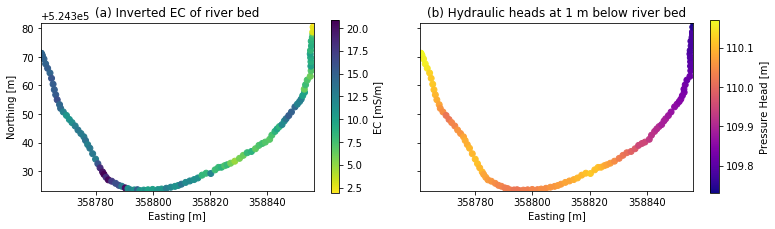

In [34]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,3))
ax = axs[0]
k.showSlice(islice=1, ax=ax)
ax.set_title('(a) Inverted EC of river bed')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_aspect('equal')
ax = axs[1]
ax.set_title('(b) Hydraulic heads at 1 m below river bed')
df = k.surveys[0].df
cax = ax.scatter(df['x'], df['y'], s=35, c=df['H100cm(m)'], cmap='plasma')
ax.set_xlabel('Easting [m]')
ax.set_aspect('equal')
fig.colorbar(cax, ax=ax, label='Pressure Head [m]')
fig.tight_layout()
fig.savefig(outputdir + 'river-layer2.jpg', dpi=500)

## CS vs Maxwell on synthetic conductive models
- Graph 1: homogeneous conductivity increase (X) vs apparent modelled (Y) for CS and FS 
- Graph 2: different height (X) vs apparent modelled (Y) for CS and FS 

In [16]:
# parameters for the synthetic model
coils = ['VCP4.49f10000h0', 'VCP4.49f10000h1']

# homogenous ground
condsHomo = np.ones((100,2))*np.arange(100)[:,None]+1
depths = np.ones((100,1))*1

# heterogeneous ground
condsHetero = np.ones((100,2))*np.arange(100)[:,None]+1
condsHetero[:,1] = 50
depths = np.ones((100,1))*0.5

# forward modelling
k = Problem()
k.setModels([depths, depths],[condsHomo, condsHetero])
dfsFSeq = k.forward(forwardModel='FSeq', coils=coils)
dfsFSlin = k.forward(forwardModel='FSlin', coils=coils)
dfsCS = k.forward(forwardModel='CS', coils=coils)

Forward modelling
Forward modelling
Forward modelling


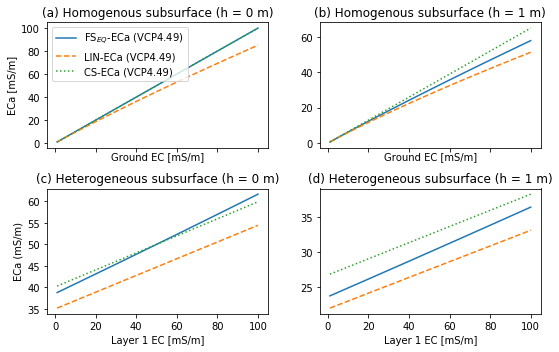

In [17]:
# figure
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8, 5))
axs = axs.flatten()
ax = axs[0]
ax.set_title('(a) Homogenous subsurface (h = 0 m)')
ax.plot(condsHomo[:,0], dfsFSeq[0][coils[0]], '-', label = r'FS$_{EQ}$-ECa (VCP4.49)')
ax.plot(condsHomo[:,0], dfsFSlin[0][coils[0]], '--', label = 'LIN-ECa (VCP4.49)')
ax.plot(condsHomo[:,0], dfsCS[0][coils[0]], ':', label = 'CS-ECa (VCP4.49)')
ax.set_ylabel('ECa [mS/m]')
ax.set_xlabel('Ground EC [mS/m]')
ax.legend()

ax = axs[1]
ax.set_title('(b) Homogenous subsurface (h = 1 m)')
ax.plot(condsHomo[:,0], dfsFSeq[0][coils[1]], '-')
ax.plot(condsHomo[:,0], dfsFSlin[0][coils[1]], '--')
ax.plot(condsHomo[:,0], dfsCS[0][coils[1]], ':')
ax.set_xlabel('Ground EC [mS/m]')

ax = axs[2]
ax.set_title('(c) Heterogeneous subsurface (h = 0 m)')
ax.plot(condsHetero[:,0], dfsFSeq[1][coils[0]], '-')
ax.plot(condsHetero[:,0], dfsFSlin[1][coils[0]], '--')
ax.plot(condsHetero[:,0], dfsCS[1][coils[0]], ':')
ax.set_ylabel('ECa (mS/m)') 
ax.set_xlabel('Layer 1 EC [mS/m]')

ax = axs[3]
ax.set_title('(d) Heterogeneous subsurface (h = 1 m)')
ax.plot(condsHetero[:,0], dfsFSeq[1][coils[1]], '-')
ax.plot(condsHetero[:,0], dfsFSlin[1][coils[1]], '--')
ax.plot(condsHetero[:,0], dfsCS[1][coils[1]], ':')
ax.set_xlabel('Layer 1 EC [mS/m]') 

fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell.jpg', dpi=500)

## CS vs Maxwell on synthetic conductive models
- Graph 1: homogeneous conductivity increase (X) vs apparent modelled (Y) for CS and FS 
- Graph 2: different height (X) vs apparent modelled (Y) for CS and FS

Forward modelling
Forward modelling
Forward modelling
Forward modelling


  5%|▌         | 1/20 [00:00<00:02,  7.16it/s]

Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


  0%|          | 0/20 [00:00<?, ?it/s]


Survey 1/1


100%|██████████| 20/20 [00:31<00:00,  2.67s/it]


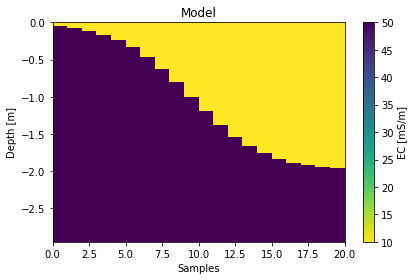

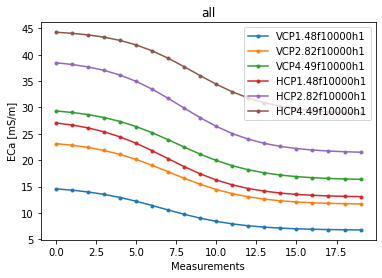

In [23]:
# parameters for the synthetic model
nlayer = 2 # number of layers
npos = 20 # number of positions/sampling locations
conds = np.ones((npos, nlayer))*[10, 50] # EC in mS/m
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1))) # depth of model

# defines coils configuration, frequency and height above the ground
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']

# foward modelling
ks = []
for i, coils in enumerate([coils0, coils1, coils0, coils1]):
    k = Problem()
    k.setModels([depths], [conds])
    _ = k.forward(forwardModel='FSeq', coils=coils, noise=0.0)
    ks.append(k)
k.showResults() # display original model
k.show() # display ECa computed from forward modelling

for k, fm in zip(ks, ['FSeq','FSeq','CS','CS']):
    k.setInit(depths0=[0.5], fixedDepths=[False],
              conds0=[20, 20], fixedConds=[False, False]) # set initial values
    # invert using ROPE solver (RObust Parameter Estimation)
    k.invert(forwardModel=fm, method='ROPE', regularization='l1', alpha=0,
             bnds=[(0.01, 3), (0, 80), (0, 80)], rep=3000, njobs=-1)

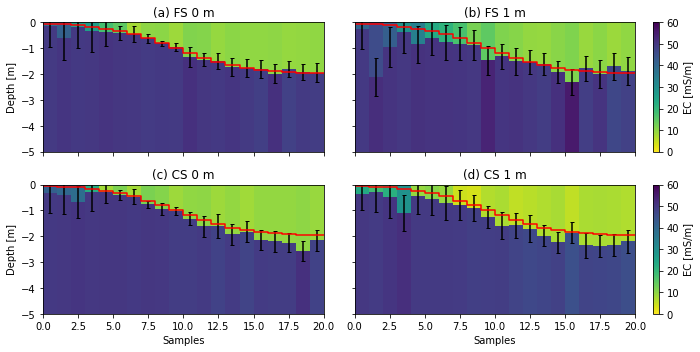

In [24]:
# figure
titles = ['(a) FS 0 m', '(b) FS 1 m', '(c) CS 0 m', '(d) CS 1 m']
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=0, vmax=60, maxDepth=5, errorbar=True)
    ax.step(-np.vstack([depths, depths[-1,:]]), 'r-', where='post')
    if i % 2 == 0:
        fig.axes[-1].remove() # remove colorbar
    else:
        ax.set_ylabel('')
    if i < 2:
        ax.set_xlabel('')
    ax.set_title(titles[i])
fig.tight_layout()
fig.savefig(outputdir + 'cs-maxwell-inv.jpg', dpi=500)

## Calibrated and not calibrated ERT with Boxford dataset

In [6]:
#invert ERT data
sys.path.append('/home/pmclachlan/pyr2/src')
from resipy import R2

kres = R2(datadir + 'boxford-calib/wd') # create an R2 object and set the working directory
kres.dirname = datadir + 'boxford-calib/wd'
kres.createSurvey(datadir + 'boxford-calib/protocol.dat', ftype='Protocol') # read the survey file
kres.elec = np.zeros((96,3))
kres.elec[:,0] = np.arange(0, 96*0.5, 0.5)
kres.createMesh(typ='quad', elemx=2, xgf=2, zf=1.25, zgf=2,doi=4) # generate quadrilateral mesh
kres.param['data_type'] = 1 # use log resisitivity
kres.param['a_wgt'] = 0.02
kres.param['b_wgt'] = 0.01
kres.invert()

API path =  /home/pmclachlan/pyr2/src/resipy
ResIPy version =  2.0.2
Working directory is: /home/pmclachlan/emagpy/src/examples/boxford-calib/wd
clearing the dirname
Inf or NaN: filterData: 0 / 2171 quadrupoles removed.
strange quadrupoles: filterData: 0 / 2171 quadrupoles removed.
2171/2171 reciprocal measurements NOT found.
0 measurements error > 20 %
magErr/phiErr columns detected, will be used in protocol.dat
computed DOI : -6.00
written mesh.dat file to 
examples/boxford-calib/wd/mesh.dat
Writing .in file and protocol.dat...
written mesh.dat file to 
examples/boxford-calib/wd/mesh.dat
done!

--------------------- MAIN INVERSION ------------------



 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v3.3 <<

 >> D a t e : 12 - 03 - 2020
 >> My beautiful survey
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivit

In [7]:
# load inverted data
sys.path.append('/home/pmclachlan/pyr2/src')
from resipy import R2

kres = R2()
kres.dirname = datadir + 'boxford-calib/wd'
kres.createSurvey(datadir + 'boxford-calib/protocol.dat', ftype='Protocol') # read the survey file
kres.elec = np.zeros((96,3))
kres.elec[:,0] = np.arange(0, 96*0.5, 0.5)
kres.createMesh(typ='quad', elemx=2, xgf=2, zf=1.25, zgf=2,doi=4) # generate quadrilateral mesh
kres.getResults()

Working directory is: /home/pmclachlan/pyr2/src/resipy/invdir
clearing the dirname
Inf or NaN: filterData: 0 / 2171 quadrupoles removed.
strange quadrupoles: filterData: 0 / 2171 quadrupoles removed.
2171/2171 reciprocal measurements NOT found.
0 measurements error > 20 %
magErr/phiErr columns detected, will be used in protocol.dat
computed DOI : -6.00
written mesh.dat file to 
examples/boxford-calib/wd/mesh.dat
reading  examples/boxford-calib/wd/f001_res.vtk ...done


In [8]:
# Convert resistivity to conductivity in mS/m
res = kres.meshResults[0].attr_cache['Resistivity(Ohm-m)']
kres.meshResults[0].attr_cache['Conductivity(mS/m)'] = 1000/np.array(res)

  0%|          | 0/43 [00:00<?, ?it/s]

Survey 1/1


100%|██████████| 43/43 [00:05<00:00,  8.23it/s]



VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)
HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)


  0%|          | 0/43 [00:00<?, ?it/s]

VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)
HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)
Correction is applied.
Survey 1/1


100%|██████████| 43/43 [00:04<00:00,  8.63it/s]


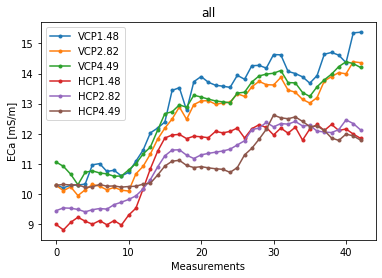

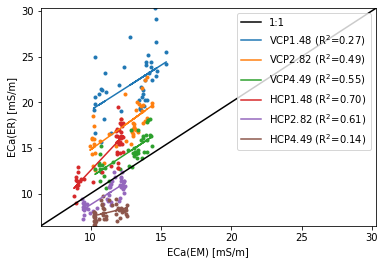

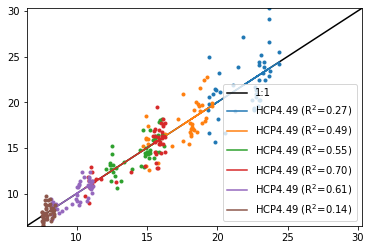

In [29]:
fnameEC = datadir + 'boxford-calib/eri_ec.csv'
fnameECa = datadir + 'boxford-calib/eca_calibration2.csv'

# non calibrated
k1 = Problem()
k1.createSurvey(fnameECa)
k1.show()
k1.setInit(depths0=np.arange(0.05, 3, 0.05))
k1.invert(alpha=0.001,njobs=-1)

# ERT calibrated
k2 = Problem()
k2.createSurvey(fnameECa)
k2.calibrate(fnameECa, fnameEC, forwardModel='FSeq') # plot calibration
k2.calibrate(fnameECa, fnameEC, forwardModel='FSeq', apply=True) # apply the calibration
k2.setInit(depths0=np.arange(0.05, 3, 0.05))
k2.invert(alpha=0.001,njobs=-1)

VCP1.48: ECa(ERT) = 0.98 * ECa(EMI) + 9.28 (R^2=0.27)
VCP2.82: ECa(ERT) = 1.10 * ECa(EMI) + 3.77 (R^2=0.49)
VCP4.49: ECa(ERT) = 1.01 * ECa(EMI) + 1.65 (R^2=0.55)
HCP1.48: ECa(ERT) = 1.64 * ECa(EMI) + -3.87 (R^2=0.70)
HCP2.82: ECa(ERT) = 0.97 * ECa(EMI) + -0.95 (R^2=0.61)
HCP4.49: ECa(ERT) = 0.36 * ECa(EMI) + 3.87 (R^2=0.14)


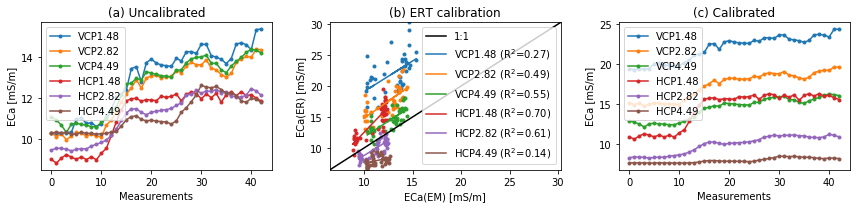

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
ax = axs[0]
k1.show(ax=ax)
ax.set_title('(a) Uncalibrated')
ax = axs[1]
ax.set_title('(b) ERT calibration')
k2.calibrate(fnameECa, datadir + 'boxford-calib/eri_ec.csv', forwardModel='FSeq', ax=ax)
ax = axs[2]
k2.show(ax=ax)
ax.set_title('(c) Calibrated')
fig.tight_layout()

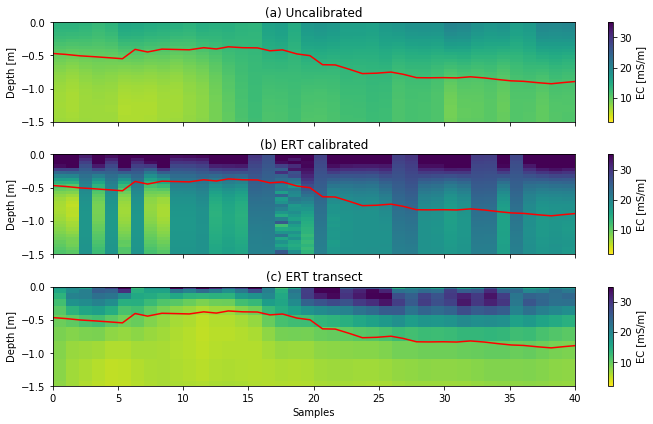

In [28]:
fig, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(10,6))
peatdepths = pd.read_csv(datadir + 'boxford-calib/peat depth.dat', sep="\t")
ax = axs[0]
k1.showResults(ax=ax, vmin=2, vmax=35)
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_title('(a) Uncalibrated')
ax.set_xlabel('')
ax = axs[1]
k2.showResults(ax=ax, vmin=2, vmax=35)
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_title('(b) ERT calibrated')
ax.set_xlabel('')
ax = axs[2]
kres = Problem()
kres.importModel(datadir + 'boxford-calib/wd/ertSection.csv')
kres.models[0] = kres.models[0][::4,:] # because taken avery 0.25 m
kres.depths[0] = kres.depths[0][::4,:]
kres.showResults(ax=ax, vmin=2, vmax=35, maxDepth=1.5)
#kres.showResults(ax=ax, contour=False, attr='Conductivity(mS/m)', zlim=[-1.5, 0], vmin=2, vmax=35, color_map='viridis_r')
ax.set_title('(c) ERT transect')
ax.plot(peatdepths['distance (m)'], -peatdepths['depth (m)'], 'r-')
ax.set_xlim([0, 40])
ax.set_aspect('auto')
fig.tight_layout()
fig.savefig(outputdir + 'calibrated-inv.jpg', dpi=500)

## Sharp and smooth inversions of Devon’s data on saprolite

In [40]:
#TODO bring in explorer data in the inversion
k1 = Problem()
k1.createSurvey(datadir + 'saprolite/mexpl.csv')
k1.setInit(depths0=np.arange(0.05, 3, 0.05))
k1.invert(forwardModel = 'FSeq', njobs=-2,alpha=0.01)

k2 = Problem()
k2.createSurvey(datadir + 'saprolite/mexpl.csv')
k2.setInit(depths0=np.array([0.5]), fixedDepths=[False], conds0=[15, 7])
k2.invert(method='ROPE', forwardModel = 'FSeq', bnds=[(0.2, 0.7), (10,25), (0, 15)], njobs=-2)

  0%|          | 0/30 [00:00<?, ?it/s]

Survey 1/1


  0%|          | 0/30 [00:00<?, ?it/s]


Survey 1/1


100%|██████████| 30/30 [00:01<00:00, 28.19it/s]


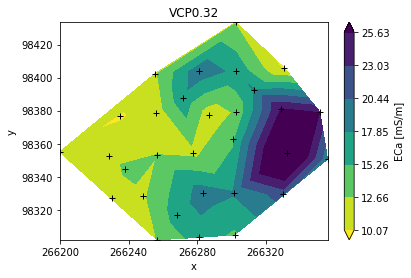

In [35]:
fig, ax = plt.subplots()
k1.showMap(contour=True, pts=True, ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

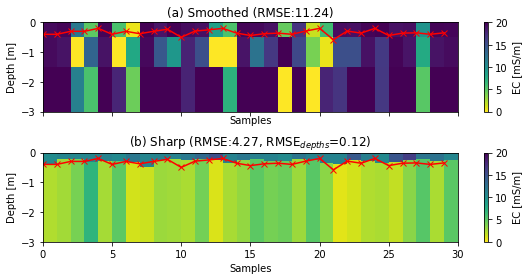

In [38]:
# graph
fig, axs = plt.subplots(2, 1, figsize=(8,4), sharex=True, sharey=True)
ax = axs[0]
k1.showResults(ax=ax, vmin=0, vmax=20, maxDepth=3)
rmse = k1.getRMSE()['all'].values[0]
ax.set_title('(a) Smoothed (RMSE:{:.2f})'.format(rmse))
ax.plot(-k1.surveys[0].df['saproliteDepth'], 'rx-')
ax = axs[1]
k2.showResults(ax=ax, vmin=0, vmax=20, maxDepth=3)
rmse = k2.getRMSE()['all'].values[0]
trueDepths = k2.surveys[0].df['saproliteDepth'].values
rmseDepths = np.sqrt(np.sum((k2.depths[0][:,0] - trueDepths)**2)/len(trueDepths))
ax.set_title('(b) Sharp (RMSE:{:.2f}, RMSE$_{{depths}}$={:.2f})'.format(rmse, rmseDepths))
ax.plot(-k1.surveys[0].df['saproliteDepth'], 'rx-')
fig.savefig(outputdir + 'smooth-sharp.jpg', dpi=500)

## Effect of noise and height on the inversion - Guillaume
- Similar to Paul’s thesis graph: adding noise make the inversion less reliable 
- Graph with increasing noise level on a 2D model ? 

/home/pmclachlan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


Forward modelling
Forward modelling
Forward modelling
Forward modelling


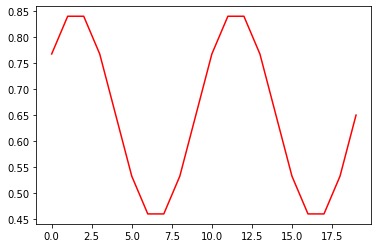

In [33]:
# parameters for the synthetic model
nlayer = 2
npos = 20
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
#depths = 0 + 2/(1+np.exp(-4*(x-1))) # sigmoid
depths = 0.65 + 0.2 * np.sin(x*np.pi*2) # wave

fig, ax = plt.subplots()
ax.plot(depths, 'r-')
fig.show()

#coils0 = ['VCP0.32', 'VCP0.71', 'VCP1.18', 'HCP0.32', 'HCP0.71', 'HCP1.18']
#coils1 = ['VCP0.32f30000h1', 'VCP0.71f30000h1', 'VCP1.18f30000h1',
#         'HCP0.32f30000h1', 'HCP0.71f30000h1', 'HCP1.18f30000h1']
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
coils1 = ['VCP1.48f10000h1', 'VCP2.82f10000h1', 'VCP4.49f10000h1',
          'HCP1.48f10000h1', 'HCP2.82f10000h1', 'HCP4.49f10000h1']
titles = ['at 0 m (no noise)', 'at 0 m (5% noise)',
          'at 1 m (no noise)', 'at 1 m (5% noise)']

# 0 m no noise
k1 = Problem()
k1.setModels([depths], [conds])
dfs = k1.forward(forwardModel='FSeq', coils=coils0, noise=0)

# at 0 m with noise
k2 = Problem()
k2.setModels([depths], [conds])
dfs = k2.forward(forwardModel='FSeq', coils=coils0, noise=0.05)

# 1 m no noise
k3 = Problem()
k3.setModels([depths], [conds])
dfs = k3.forward(forwardModel='FSeq', coils=coils1, noise=0)

# at 1 m with noise
k4 = Problem()
k4.setModels([depths], [conds])
dfs = k4.forward(forwardModel='FSeq', coils=coils1, noise=0.05)

ks = [k1, k2, k3, k4]

# invert
for k in ks:
    k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
    k.invert(forwardModel='FSeq', method='ROPE', bnds=[(0.05, 2.5), (5, 150), (5, 150)], regularization='l1', rep=1000, njobs=-1)

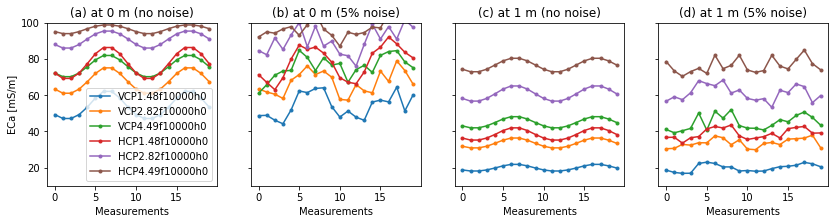

In [34]:
# graph of apparent values
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].show(ax=ax, vmin=10, vmax=100)
    ax.set_title('({:s}) {:s}'.format(letters[i], titles[i]))
    if i > 0:
        ax.get_legend().remove()
        ax.set_ylabel('')

In [35]:
# invert
for k in ks:
    k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
    k.invert(forwardModel='FSeq', method='ROPE', bnds=[(0.05, 2.5), (5, 150), (5, 150)], regularization='l1', rep=1000, njobs=-1)

100%|██████████| 20/20 [00:00<00:00, 185.63it/s]

Survey 1/1



100%|██████████| 20/20 [00:00<00:00, 2031.98it/s]


Survey 1/1



100%|██████████| 20/20 [00:00<00:00, 15632.89it/s]


Survey 1/1



100%|██████████| 20/20 [00:00<00:00, 306.93it/s]


Survey 1/1


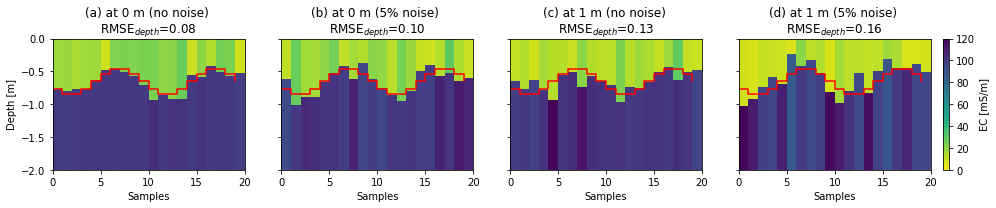

In [36]:
# graph of inverted values
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].showResults(ax=ax, vmin=0, vmax=120, maxDepth=2)
    rmseDepths = np.sqrt(np.sum((ks[i].depths[0][:,0] - depths[:,0])**2)/len(depths[:,0]))
    ax.set_title('({:s}) {:s} \nRMSE$_{{depth}}$={:.2f}'.format(letters[i], titles[i], rmseDepths))
    ax.step(np.arange(depths.shape[0]), -depths, 'r', where='post') # true depth
    if i < 3:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
fig.savefig(outputdir + 'inv-noise.jpg', dpi=500)

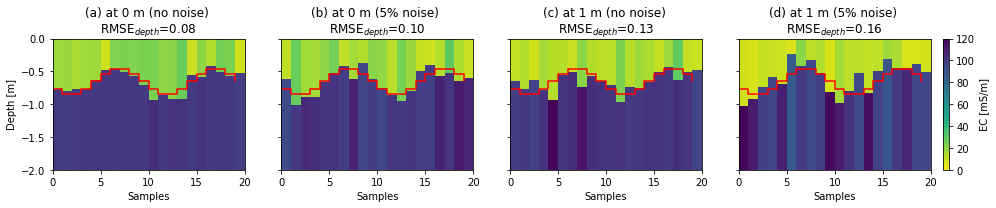

In [37]:
# graph of inverted values
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14,3))
for i in range(4):
    ax = axs[i]
    ks[i].showResults(ax=ax, vmin=0, vmax=120, maxDepth=2)
    rmseDepths = np.sqrt(np.sum((ks[i].depths[0][:,0] - depths[:,0])**2)/len(depths[:,0]))
    ax.set_title('({:s}) {:s} \nRMSE$_{{depth}}$={:.2f}'.format(letters[i], titles[i], rmseDepths))
    ax.step(np.arange(depths.shape[0]), -depths, 'r', where='post') # true depth
    if i < 3:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
fig.savefig(outputdir + 'inv-noise.jpg', dpi=500)

In [38]:
# graph noise level vs RMSE of predicted depth (takes a long time)
noises = np.linspace(0, 0.1, 10)
def computeRMSE(x, y):
    return np.sqrt(np.sum((x - y)**2)/len(x))
dfrmse = pd.DataFrame(noises, columns=['noise'])
dfrmse['h0'] = np.nan
dfrmse['h1'] = np.nan
for i, coils in zip(['h0','h1'], [coils0, coils1]):
    tmp = []
    for j, noise in enumerate(noises):
        k = Problem()
        k.models = [conds]
        k.depths = [depths]
        dfs = k.forward(forwardModel='FSeq', coils=coils, noise=noise)
        k.setInit(depths0=np.array([0.5]), fixedDepths=[False])
        k.invert(method='ROPE', bnds=[(10, 30), (80, 120), (0.1, 3)])
#        k.invert(fixedDepths=False)
        dfrmse.loc[j, i] = computeRMSE(depths, k.depths[0].flatten())
        print(dfrmse)

Forward modelling
ERROR: initial parameters values [ 0.5 20.  20. ] are out of the given bounds.Please use Problem.setInit() to define initial values or modify the boudns.

IndexError: list index out of range

Text(0, 0.5, 'RMSE of depth [m]')

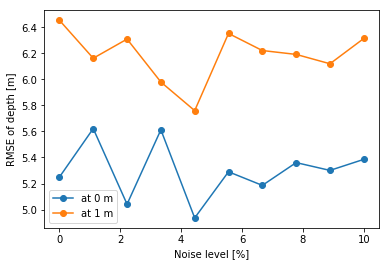

In [18]:
fig, ax = plt.subplots()
ax.plot(dfrmse['noise']*100, dfrmse['h0'], 'o-', label='at 0 m')
ax.plot(dfrmse['noise']*100, dfrmse['h1'], 'o-', label='at 1 m')
ax.legend()
ax.set_xlabel('Noise level [%]')
ax.set_ylabel('RMSE of depth [m]')

### Obervations
- Increasing the depth of 1 m above the ground make it much more difficult to define the boundary between the layers. Even more when the noise level of the measurements increase.
- at 1 m is always worse but there is no substantial increase of RMSE with noise level

## Time-lapse field application - Guillaume 
- Soil moisture content evolution vs EMI timelapse inversion 
- Quebec data, warren data or synthetic 

In [6]:
# inversion of change
fnames = [
        datadir + 'timelapse-wheat/2017-03-16.csv',
        datadir + 'timelapse-wheat/2017-04-03.csv',
        datadir + 'timelapse-wheat/2017-04-27.csv',
        datadir + 'timelapse-wheat/2017-05-16.csv']
k = Problem()
k.createTimeLapseSurvey(fnames) # import all surveys
k.setInit(depths0=np.linspace(0.1, 2, 10)) # smooth multiple fixed depths model
k.computeApparentChange() # compute change in ECa compared to first survey
k.invert(forwardModel='CSgn', alpha=0.07) # Gauss-Newton routine

Trimming surveys and only keep common positions
Matching positions between surveys for time-lapse inversion...20 in common...done in 0.0405s
Computing relative ECa compared to background (1st survey).
Survey 1/4
20/20 inverted
Survey 2/4
20/20 inverted
Survey 3/4
20/20 inverted
Survey 4/4
20/20 inverted


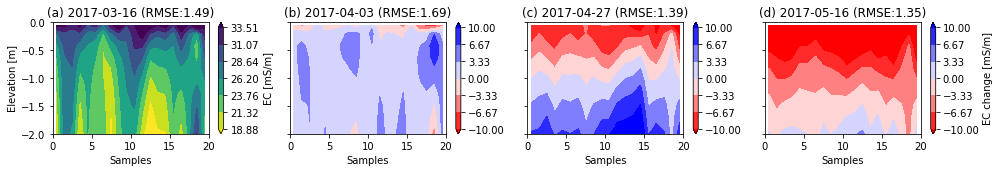

In [7]:
# graph of inverted conductivities change relative to background
rmse = k.getRMSE()
fig, axs = plt.subplots(1, 4, figsize=(14, 2.5), sharex=True, sharey=True)
axs = axs.flatten()
for i, s in enumerate(k.surveys):
    ax = axs[i]
    if i == 0:
        k.showResults(i, ax=ax, contour=True, maxDepth=2)
    else:
        k.showResults(i, ax=ax, vmin=-10, vmax=10, cmap='bwr_r', contour=True, maxDepth=2)
    ax.set_title('({:s}) {:s} (RMSE:{:.2f})'.format(letters[i], s.name, rmse['all'].values[i]))
    if i > 2:
        fig.axes[-1].set_ylabel('EC change [mS/m]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
fig.tight_layout()
fig.savefig(outputdir + 'inv-timelapse.jpg', dpi=500)

In [8]:
fnamesWC = [
        datadir + 'timelapse-wheat/170316_wc.csv',
        datadir + 'timelapse-wheat/170405_wc.csv',
        datadir + 'timelapse-wheat/170426_wc.csv',
        datadir + 'timelapse-wheat/170518_wc.csv',
        ]
kwc = Problem()
kwc.importModel(fnamesWC)
for i in range(len(fnamesWC)):
    kwc.models[i] = kwc.models[i][30:50,:]
    kwc.depths[i] = kwc.depths[i][30:50,:]
kwc.computeChange()

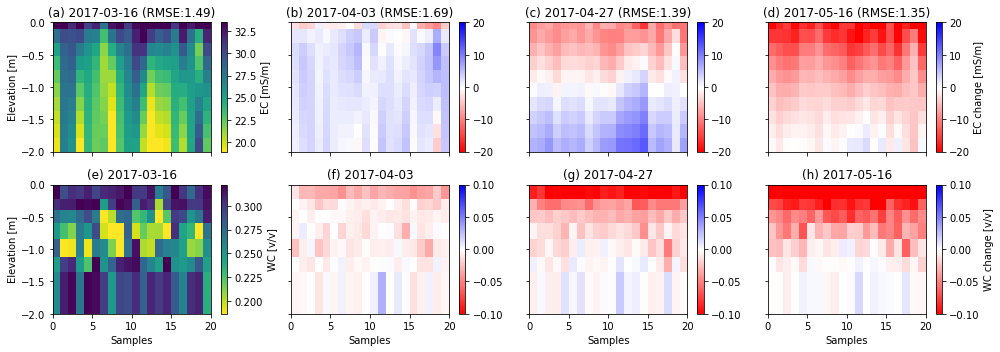

In [11]:
# graph of inverted conductivities change relative to background
rmse = k.getRMSE()
fig, axs = plt.subplots(2, 4, figsize=(14, 5), sharex=True, sharey=True)
for i, s in enumerate(k.surveys):
    ax = axs[0, i]
    if i == 0:
        k.showResults(i, ax=ax, contour=False, maxDepth=2)
    else:
        k.showResults(i, ax=ax, vmin=-20, vmax=20, cmap='bwr_r', contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s} (RMSE:{:.2f})'.format(letters[i], s.name, rmse['all'].values[i]))
    ax.set_xlabel('')
    if i > 2:
        fig.axes[-1].set_ylabel('EC change [mS/m]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
    
    ax = axs[1, i]
    if i == 0:
        kwc.showResults(i, ax=ax, contour=False, maxDepth=2)
        fig.axes[-1].set_ylabel('WC [v/v]')
    else:
        kwc.showResults(i, ax=ax, cmap='bwr_r', vmin=-0.1, vmax=0.1, contour=False, maxDepth=2)
    ax.set_title('({:s}) {:s}'.format(letters[i+4], s.name))
    if i > 2:
        fig.axes[-1].set_ylabel('WC change [v/v]')
    if i > 0:
        ax.set_ylabel('')
        if i != 3:
            fig.axes[-1].set_ylabel('')
fig.tight_layout()
fig.savefig(outputdir + 'inv-timelapse2.jpg', dpi=500)

## Different types of inversions

In [35]:
# Gauss-Newton
k1 = Problem()
k1.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k1.setInit(depths0=np.linspace(0.1, 2, 20))
k1.surveys[0].df = k1.surveys[0].df[:20]
k1.invertGN()

# Minimize
k2 = Problem()
k2.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k2.setInit(depths0=np.array([0.3, 0.7]), fixedDepths=[True, True])
k2.surveys[0].df = k2.surveys[0].df[:20]
k2.invert(method='L-BFGS-B')

# MCMC
k3 = Problem()
k3.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k3.setInit(depths0=np.array([0.7]), fixedDepths=[False])
k3.surveys[0].df = k3.surveys[0].df[:20]
k3.invert(method='ROPE', rep=500)

ks = [k1, k2, k3]

Survey 1/1
20/20 inverted
Survey 1/1
20/20 inverted
Survey 1/1
20/20 inverted


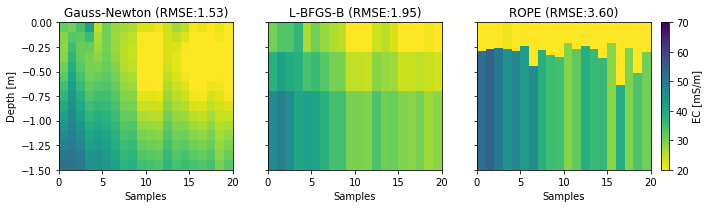

In [36]:
# graph
methods = ['Gauss-Newton', 'L-BFGS-B', 'ROPE']
fig, axs = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
for i, k in enumerate(ks):
    ax = axs[i]
    k.showResults(ax=ax, vmin=20, vmax=70, maxDepth=1.5)
    if i < 2:
        fig.axes[-1].remove()
    if i > 0:
        ax.set_ylabel('')
    rmse = k.getRMSE()
    ax.set_title('{:s} (RMSE:{:.2f})'.format(methods[i], rmse['all'].values[0]))
fig.savefig(outputdir + 'inversion-types.jpg', dpi=500)

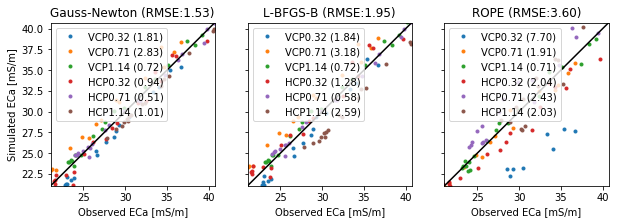

In [37]:
# graph of one2one
fig, axs = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
for i, k in enumerate(ks):
    ax = axs[i]
    k.showOne2one(ax=ax)
    if i > 0:
        ax.set_ylabel('')
    rmse = k.getRMSE()
    ax.set_title('{:s} (RMSE:{:.2f})'.format(methods[i], rmse['all'].values[0]))

## Capabilities of EMagPy

Forward modelling
Deleted 13/60 measurements
dataset shrunk of 2 measurements
VCP0.71 0.53 * x + 2.34 (R=0.54)
HCP0.71 0.22 * x + 10.44 (R=0.22)
Transformation to LIN ECa for CMD Mini-Explorer at F-0m calibration
found 766 / 3792 crossing points
bounds = None
Survey 1/1
45 measurements inverted (0 converged)


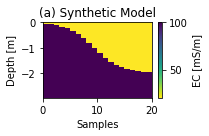

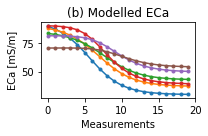

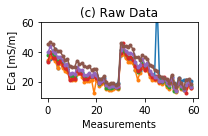

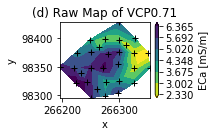

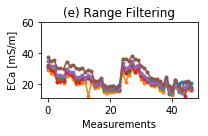

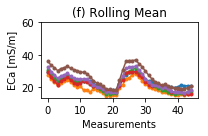

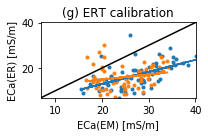

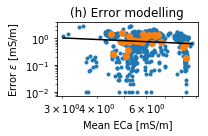

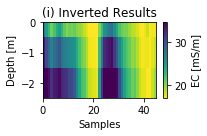

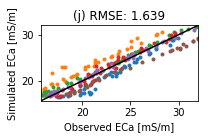

In [12]:
figsize = (3,2)

# forward modelling
nlayer = 2
npos = 20
conds = np.ones((npos, nlayer))*[20, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depths = 0 + 2/(1+np.exp(-4*(x-1)))
coils0 = ['VCP1.48f10000h0', 'VCP2.82f10000h0', 'VCP4.49f10000h0',
          'HCP1.48f10000h0', 'HCP2.82f10000h0', 'HCP4.49f10000h0']
k = Problem()
k.setModels([depths], [conds])
dfs = k.forward(forwardModel='FS', coils=coils0, noise=0)

fig, ax = plt.subplots(figsize=figsize)
k.showResults(ax=ax)
ax.set_title('(a) Synthetic Model')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-model.jpg')

fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax)
ax.get_legend().remove()
ax.set_title('(b) Modelled ECa')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-forward-show.jpg')


# create EMI model
k = Problem()
k.createSurvey(datadir + 'cover-crop/coverCrop.csv')
k.surveys[0].df = k.surveys[0].df[:60]
#k.coils = k.coils[:3] # just VCP
#k.surveys[0].coils = k.surveys[0].coils[:3]

# data display
fig, ax = plt.subplots(figsize=figsize)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(c) Raw Data')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-show.jpg')

# data map
fig, ax = plt.subplots(figsize=figsize)
k2 = Problem()
k2.createSurvey(datadir + 'saprolite/regolith.csv')
k2.convertFromNMEA()
k2.showMap(coil=k2.coils[1], ax=ax, contour=True, pts=True)
ax.set_title('(d) Raw Map of VCP0.71')
fig.axes[-1].set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showMap.jpg')

# filter range
fig, ax = plt.subplots(figsize=figsize)
k.filterRange(vmin=10, vmax=40)
k.show(ax=ax, vmax=60)
ax.get_legend().remove()
ax.set_title('(e) Range Filtering')
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-filterRange.jpg')

# filter pick
#fig, ax = plt.subplots()
#k.show(ax=ax, vmax=60)
#fig.savefig(outputdir + 'cap-filterPick.jpg')

# filter smooth
fig, ax = plt.subplots(figsize=figsize)
k.rollingMean()
k.show(ax=ax, vmax=60)
ax.set_title('(f) Rolling Mean')
ax.get_legend().remove()
ax.set_ylabel('ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-smooth.jpg')

# ERT calibration
fig, ax = plt.subplots(figsize=figsize)
k.calibrate(datadir + 'calib/dfeca2.csv', datadir + 'calib/dfec.csv', ax=ax)
ax.get_legend().remove()
ax.set_title('(g) ERT calibration')
fig.tight_layout()
fig.savefig(outputdir + 'cap-calib.jpg')

# EMI error modelling
k2 = Problem() # need other dataset as cover-crop doesn't have cross-over points
k2.importGF(fnameLo = datadir + 'potatoes/potatoesLo.dat')
k2.convertFromNMEA()
fig, ax = plt.subplots(figsize=figsize)
k2.crossOverPoints(ax=ax, coil=k.coils[1])
ax.set_title('(h) Error modelling')
ax.get_legend().remove()
ax.set_xlabel('Mean ECa [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-error.jpg')

# Inverse results
fig, ax = plt.subplots(figsize=figsize)
k.invert()
k.showResults(ax=ax, contour=False)
ax.set_title('(i) Inverted Results')
fig.axes[-1].set_ylabel('EC [mS/m]')
fig.tight_layout()
fig.savefig(outputdir + 'cap-showResults.jpg')

# Inverse quality
fig, ax = plt.subplots(figsize=figsize)
k.showOne2one(ax=ax)
ax.get_legend().remove()
ax.set_title('(j) ' + ax.get_title())
fig.tight_layout()
fig.savefig(outputdir + 'cap-one2one.jpg')

(20, 2)
(20, 3)


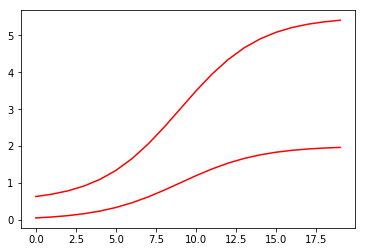

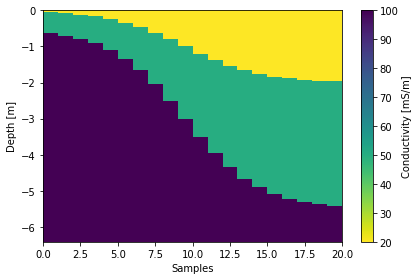

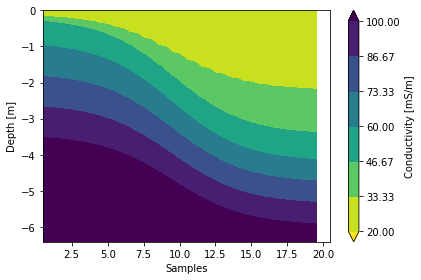

In [25]:
# illustrative graph for figure 3
nlayer = 3
npos = 20
conds = np.ones((npos, nlayer))*[20, 50, 100]
x = np.linspace(0.1, 2, npos)[:,None]
depth1 = 0 + 2/(1+np.exp(-4*(x-1)))
depth2 = 0.5 + 5/(1+np.exp(-4*(x-1)))
depths = np.c_[depth1, depth2]
fig, ax = plt.subplots()
ax.plot(depths, 'r-')
fig.show()
print(depths.shape)
print(conds.shape)
k = Problem()
k.setModels([depths], [conds])
k.showResults()
k.showResults(contour=True)